1. Open the data from your own station on the campus, merge data and save to one netCDF file


In [1]:
import os
import glob as glob
import pandas as pd
import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt
import datetime


In [3]:
# Get the location of current folder 
base_dir = "/Users/pkm/MAIO-UU/"
print(base_dir)


/Users/pkm/MAIO-UU/


In [5]:
# Move to the folder with raw data from MAIO setup
L0_folder = base_dir + "/Data/UU_Toulouselaan_2025/L0/"

os.chdir(L0_folder)

# List all the 30min data files
files = glob.glob('*30m*.txt')
print('input files: ', files)

# open each file and merge in same dataframe
for idx, file in enumerate(files):
    # open CSV file
    df = pd.read_csv(file,delimiter = ',',header=0)
    # Rename time variable
    df.rename(columns={'Time(UTC)': 'time'}, inplace=True)
    # Set time variable as dataframe index
    df = df.set_index('time')
    df.index = pd.to_datetime(df.index)
    if idx == 0:
        df_out = df
    else:
        # merge dataframes
        df_out = df_out.join(df, how='outer')

# list variables
print('variables: ', df_out.keys())


# make xarray dataset from pandas dataframe
ds = df_out.to_xarray()

# Compute hourly averages
ds_hour = ds.resample(time="1h").mean()




input files:  ['CNR1_30m.txt', 'MAIO_AWS_30min.txt', 'FLUX_30min.txt']
variables:  Index(['swd_1', 'swu_1', 'lwd_1', 'lwu_1', 't_rad_1', 'batt_v_1', 't_log_1',
       'rh_1', 'rh_2', 'rh_3', 'rh_4', 'rh_5', 't_1', 't_2', 't_3', 't_4',
       't_5', 'wspd_1', 'wdir_1', 'wspd_2', 'wdir_2', 'wspd_3', 'wdir_3',
       'wspd_4', 'wdir_4', 'wspd_5', 'wdir_5', 'uu', 'uv', 'uw', 'uTs', 'uTc1',
       'uH2O', 'vv', 'vw', 'vTs', 'vTc1', 'vH2O', 'ww', 'wTs', 'wTc1', 'wH2O',
       'TsTs', 'Tc1Tc1', 'H2OH2O', 'u', 'v', 'w', 'Ts', 'Tc1', 'H2O', 'Uyp',
       'WDy', 'WDyWDy', 'wgwg', 'wguy', 'wgTc2', 'uywg', 'uyTc2', 'Tc2Tc2',
       'wg', 'Uy', 'Tc2', 'wdir_Y'],
      dtype='object')


In [7]:
# Export dataset to net CDF in new folder
L1_folder  = base_dir + "/Data/UU_Toulouselaan_2025/L1/"

name = 'MAIO'
year = '2025'
loc = 'UUTL'
version = '1.0'
level = 'L1'
period = '1H'
oformat = 'nc'
file_out = f'{L1_folder}{name}_{year}_{loc}_{level}_{period}_{version}.{oformat}'

# Read metadata file
meta_file = base_dir + '/Metadata/variables.csv'
meta = pd.read_csv(meta_file, index_col=0, comment="#")

# Write metadata for each variable in output file
for var in list(ds_hour.variables):
     for attr in list(meta.keys()):
          if len(meta[meta.index==var][attr].values) > 0:
               ds_hour[var].attrs[attr] = meta[meta.index==var][attr].values[0]
     
# add some general attributes
ds_hour.attrs['file_creation_date_time'] = str(datetime.datetime.now())

# create output folder
if not os.path.exists(L1_folder):
     os.makedirs(L1_folder) 
os.chdir(L1_folder)

# Export to net CDF
ds_hour.to_netcdf(file_out,mode = 'w')

# go back to main folder
os.chdir(base_dir)


<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:42: SyntaxWarning: invalid escape sequence '\%'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:42: SyntaxWarning: invalid escape sequence '\%'
/var/folders/by/h5hczq_91yq95g6bngdb0ygm0000gp/T/ipykernel_92355/1529484672.py:20: SyntaxWarning: invalid escape sequence '\c'
  axs[0].set_ylabel('$T (\circ C)$')
/var/folders/by/h5hczq_91yq95g6bngdb0ygm0000gp/T/ipykernel_92355/1529484672.py:42: SyntaxWarning: invalid escape sequence '\%'
  axs[2].set_ylabel('$RH (\%)$')


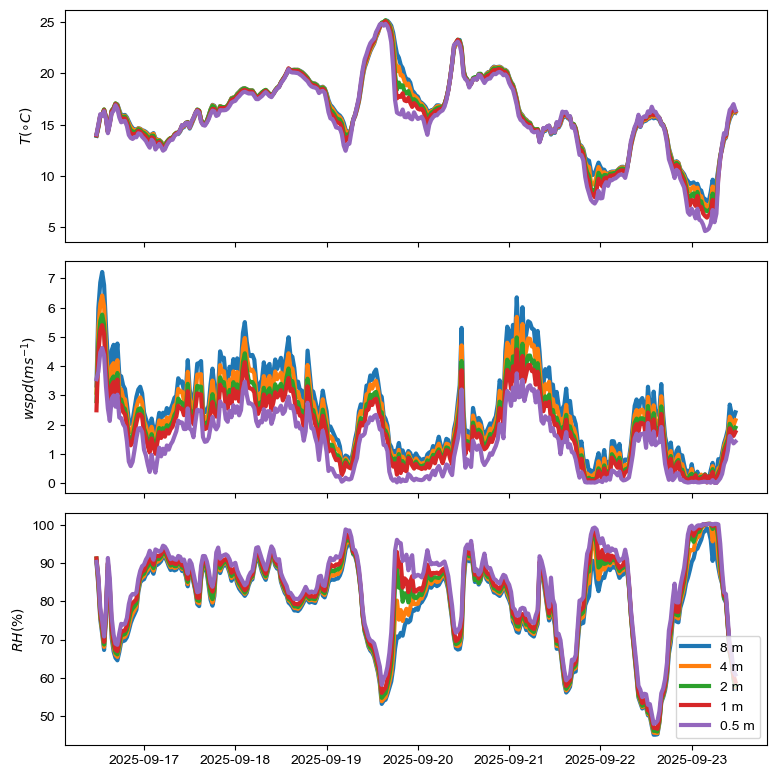

In [9]:
# Plot 
plt.rc('font', family='Arial')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

centimeters = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(3, 1, sharex=True,figsize=(20*centimeters, 20*centimeters))
# Remove horizontal space between axes
fig.subplots_adjust(bottom=0.15, wspace=0.05)

axs[0].plot(ds.time,ds.t_1,ds.time, ds.t_2,ds.time,ds.t_3,ds.time,ds.t_4,ds.time,ds.t_5,  # data
marker='None',     # each marker will be rendered as a circle
markersize=10,   # marker size
#color = '#3f79bc', # line color
markerfacecolor='red',   # marker facecolor
markeredgecolor='black',  # marker edgecolor
markeredgewidth=2,       # marker edge width
linestyle='-',            # line style will be dash line
linewidth=3)          # line width
axs[0].set_ylabel('$T (\circ C)$')

axs[1].plot(ds.time,ds.wspd_1,ds.time, ds.wspd_2,ds.time,ds.wspd_3,ds.time,ds.wspd_4,ds.time,ds.wspd_5,  # data
marker='None',     # each marker will be rendered as a circle
markersize=10,   # marker size
#color = '#3f79bc', # line color
markerfacecolor='red',   # marker facecolor
markeredgecolor='black',  # marker edgecolor
markeredgewidth=2,       # marker edge width
linestyle='-',            # line style will be dash line
linewidth=3)          # line width
axs[1].set_ylabel('$wspd (ms^{-1})$')

axs[2].plot(ds.time,ds.rh_1,ds.time, ds.rh_2,ds.time,ds.rh_3,ds.time,ds.rh_4,ds.time,ds.rh_5,  # data
marker='None',     # each marker will be rendered as a circle
markersize=10,   # marker size
#color = '#3f79bc', # line color
markerfacecolor='red',   # marker facecolor
markeredgecolor='black',  # marker edgecolor
markeredgewidth=2,       # marker edge width
linestyle='-',            # line style will be dash line
linewidth=3)          # line width
axs[2].set_ylabel('$RH (\%)$')

axs[2].legend(['8 m', '4 m', '2 m', '1 m', '0.5 m'])

fig.tight_layout()
plt.savefig(L1_folder + 'timeseries.png')

Now, we will download data from the KNMI AWS in de Bilt :
- Go to https://daggegevens.knmi.nl/klimatologie/uurgegevens
- Select all parameters ('Velden'), station de Bilt, all data since 20250915 in csv format
- save data to a new 'L0' folder in the 'KNMI_deBilt' folder 

![Alt text](image.png)



In [13]:
## Open KNMI data
# Move to the folder with raw data from KNMI website 
L0_folder = base_dir + "/Data/KNMI_deBilt/L0/"

try:
    os.chdir(L0_folder)
except ValueError:
    raise ValueError("KNMI data is not available")


# List all the data files
files = glob.glob('*txt') # change this if you have .csv files
print('input files: ', files)

# Standard variables 
column_names = ['STN','YYYYMMDD','H',   'DD',   'FH',   'FF',   'FX',    'T', 'T10N',   'TD',   'SQ',    'Q',   'DR',   'RH',    'P',   'VV',    'N',    'U',   'WW',   'IX',    'M',    'R',    'S',    'O',    'Y']

# open each file and merge in same dataframe
for idx, file in enumerate(files):
    # open CSV file
    
    df = pd.read_csv(file,delimiter = ',', comment='#',names=column_names)
    # Rename time variable
    # df.rename(columns={'Time(UTC)': 'time'}, inplace=True)
    # Set time variable as dataframe index
    # df = df.set_index('time')
    # df.index = pd.to_datetime(df.index)
    if idx == 0:
        df_out = df
    else:
        # merge dataframes
        df_out = df_out.join(df, how='outer')
# Make time index
df_out['time'] = pd.to_datetime(df_out['YYYYMMDD'], format='%Y%m%d') + pd.to_timedelta(df_out["H"], unit="h")
df_out  = df_out.set_index('time')
# list variables
print('variables: ', df_out.keys())


input files:  ['KNMI_allfields_202509.txt']
variables:  Index(['STN', 'YYYYMMDD', 'H', 'DD', 'FH', 'FF', 'FX', 'T', 'T10N', 'TD', 'SQ',
       'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'WW', 'IX', 'M', 'R', 'S', 'O',
       'Y'],
      dtype='object')


In [15]:
# convert variables
df_out['FH'] = df_out['FH']*0.1 
df_out['FF'] = df_out['FF']*0.1
df_out['FX'] = df_out['FX']*0.1
df_out['T'] = df_out['T']*0.1
df_out['TD'] = df_out['TD']*0.1
df_out['P'] = df_out['P']*0.1
df_out['Q'] = df_out['Q']*1e4/3600 # from J/cm2 to W/m2 per hour

# Keep variables of interest
colums_out = ['FH','FF','FX','T','TD','P','Q']
df_out = df_out[colums_out]

# convnert to xarray dataset
ds = df_out.to_xarray()

# Export dataset to net CDF in new folder
L1_folder  = base_dir + "/Data/KNMI_deBilt/L1/"

name = 'KNMI_AWS'
year = '2025'
loc = 'deBilt'
version = '1.0'
level = 'L1'
period = '1H'
oformat = 'nc'
file_out = f'{L1_folder}{name}_{year}_{loc}_{level}_{period}_{version}.{oformat}'

# add some general attributes
ds.attrs['file_creation_date_time']     = str(datetime.datetime.now())

# create output folder
if not os.path.exists(L1_folder):
     os.makedirs(L1_folder) 
os.chdir(L1_folder)

# Export to net CDF
ds.to_netcdf(file_out,mode = 'w')

# go back to main folder
os.chdir(base_dir)

The last step is to compare the KNMI data to our own data.
- Open the L1 file with MAIO data
- Open the L1 cile from KNMI data
- Merge variables from both datasets in a new dataset
- make some scatter plots & timeseries plots
- save plots and data to a new L2 folder 

In [18]:
MAIO_folder = base_dir + "/Data/UU_Toulouselaan_2025/L1/"
KNMI_folder  = base_dir + "/Data/KNMI_deBilt/L1/"

# Open file with MAIO data
os.chdir(MAIO_folder)
file = glob.glob('*nc')
ds_1 = xr.open_dataset(file[0])#,engine='scipy')
# Open file with KNMI data
os.chdir(KNMI_folder)
file = glob.glob('*nc')
ds_2 = xr.open_dataset(file[0])#,engine='scipy')

# Merge dataset
ds_out = xr.merge([ds_1,ds_2])

In [20]:
# Export dataset to net CDF in new folder
L2_folder  = base_dir + "/Data/UU_Toulouselaan_2025/L2/"

name = 'MAIO'
year = '2025'
loc = 'UUTL'
version = '1.0'
level = 'L2'
period = '1H'
oformat = 'nc'
file_out = f'{L2_folder}{name}_{year}_{loc}_{level}_{period}_{version}.{oformat}'

# add some general attributes
ds_out.attrs['file_creation_date_time']     = str(datetime.datetime.now())

# create output folder
if not os.path.exists(L2_folder):
     os.makedirs(L2_folder) 
os.chdir(L2_folder)

# Export to net CDF
ds_out.to_netcdf(file_out,mode = 'w')

# go back to main folder
os.chdir(base_dir)

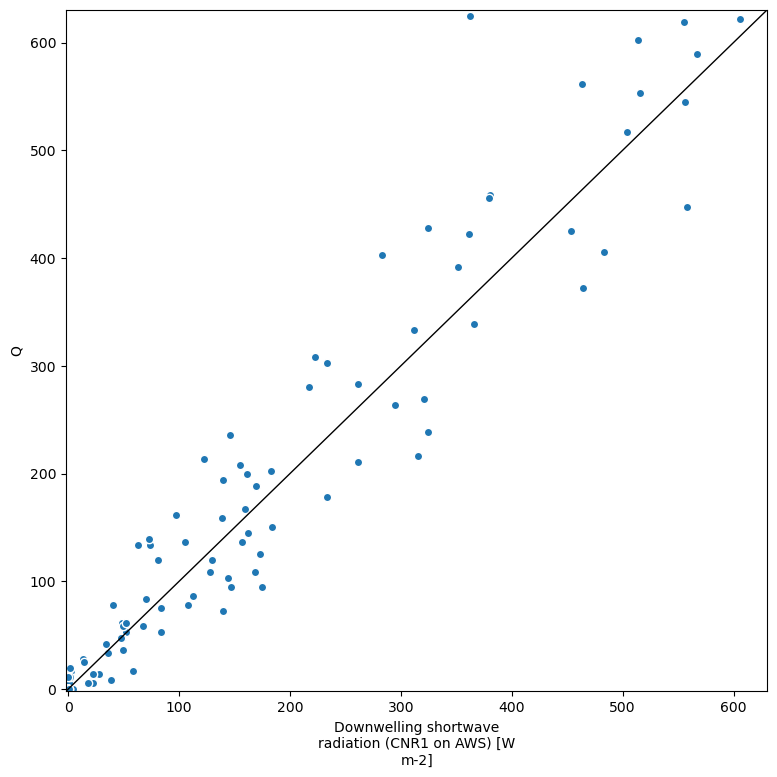

bias =  5.336530971390551
RMS =  41.31686867968087


In [24]:
# Make a scatter plot between 2 variables
os.chdir(L2_folder)

xvar = "swd_1" #T
yvar = "Q" #t_0

min = np.nanmin([np.min(ds_out[xvar]).values,np.nanmin(ds_out[yvar].values)])
max = np.nanmax([np.max(ds_out[xvar]).values,np.nanmax(ds_out[yvar].values)])

centimeters = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(20*centimeters, 20*centimeters))
plt.axline((min, min), (max, max), linewidth=1, color='k')

ds_out.plot.scatter(x=xvar, y=yvar)
plt.xlim([min,max])
plt.ylim([min,max])
plt.tight_layout()
plt.savefig('scatter_%s.png'%(xvar + yvar))
plt.show()

# COmpute bias and RMSE
bias = np.nanmean(ds_out[yvar] - ds_out[xvar])
RMS = np.sqrt(np.nanmean((ds_out[yvar] - ds_out[xvar])**2))

print('bias = ',bias)
print('RMS = ',RMS)



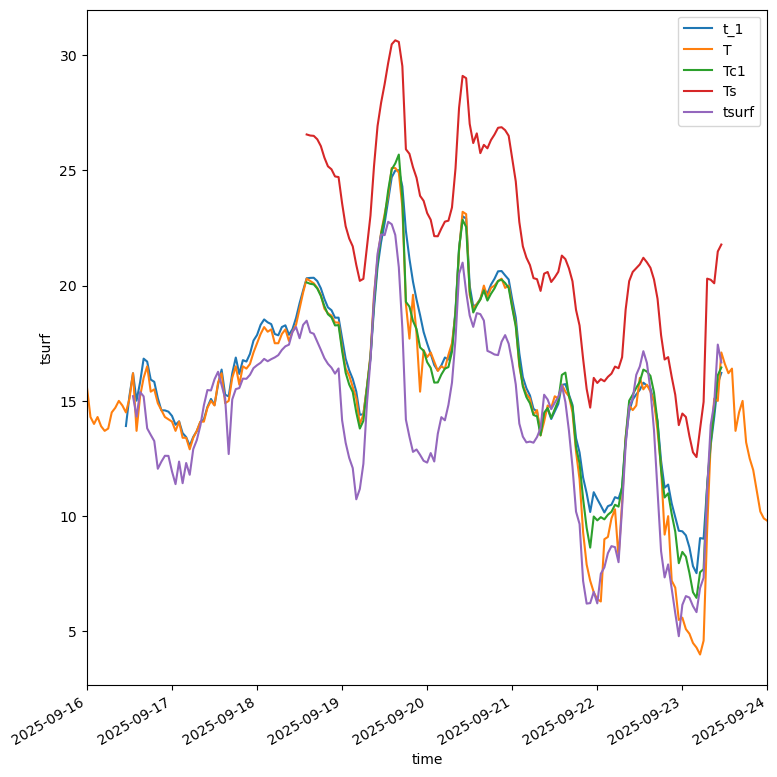

In [26]:
# calculate surface tmeperature
boltz  = 5.67e-8     # Stefan-Boltzmann constant (W/m^2/K^4)
epsilon = 0.97 # surface emissivity (-)
ds_out['tsurf'] = (ds_out['lwu_1']/ (epsilon*boltz)) ** (1/4) - 273.15

# Make a time series plot of 5 variables
os.chdir(L2_folder)

yvar_1 = "t_1"
yvar_2 = "T"
yvar_3 = "Tc1"
yvar_4 = "Ts"
yvar_5 = "tsurf"

plt.figure(figsize=(20*centimeters, 20*centimeters))
ds_out[yvar_1].plot.line()
ds_out[yvar_2].plot.line()
ds_out[yvar_3].plot.line()
ds_out[yvar_4].plot.line()
ds_out[yvar_5].plot.line()

plt.xlim(pd.Timestamp('2025-09-16'), pd.Timestamp('2025-09-24'))
plt.tight_layout()
plt.legend([yvar_1, yvar_2, yvar_3, yvar_4, yvar_5])

plt.savefig('timeseries_%s.png'%(yvar_1 + yvar_2 + yvar_3 + yvar_4 + yvar_5))
plt.show()